* 泰坦尼克灾难是kaggle的经典题目，这里结合我之前对这个题目的经验和后续参考其他大牛的分析方法，做一个汇总，希望能达到**Top3%**的水平。
* 之前尝试过对空值的进行处理（包括对年龄字段进行拟合），并且做了不少的特征工程，得到的结果往往是在cross validation中可以获得约0.85左右的得分，但是在test集中降到0.76左右。
* 后来参考过了其他同学的一些建议，发现这是一个过拟合的现象，train集和test集有一定的偏差，所以还是需要做一些特征筛选。
* 在调研过程中，有一位大牛通过对age、freq(ticket、fare和cabin的)、familysize对乘客进行**分群**，然后结合pclass和sex的条件存活概率计算log likelihood值，最后针对不同的群，对对应的log likelihood进行加权或惩罚，最后仅使用这一个特征进行预测，预测结果在样本内验证集上约0.83左右的分值，在测试集上也可以达到约0.82左右的分值，泛化效果很好。原版：https://www.kaggle.com/pliptor/divide-and-conquer-0-82296 python版：https://www.kaggle.com/krasserm/divide-and-conquer-in-python-0-82296
* 另一位做了很多和我之前类似的特征工程，但是做了特征选择，据其文档描述也达到了0.81左右的分数，

分析步骤：
- 数据基本概况
- 空值处理
- 特征工程

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

%matplotlib inline
sns.set_style("whitegrid")

## 数据基本概况

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

以下是官方提供的数据维度解释
* survival	Survival/y变量	0 = No, 1 = Yes
* pclass	Ticket class/船票等级	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex/性别	
* Age	Age in years/年龄	
* sibsp	# of siblings / spouses aboard the Titanic/同船的同胞兄弟和配偶数
* parch	# of parents / children aboard the Titanic/同船的子女和父母数
* ticket	Ticket number/ 票号
* fare	Passenger fare/　费用(后经调研，为家庭总费用)
* cabin	Cabin number/　船舱号
* embarked	Port of Embarkation/登船的港口

In [5]:
# 删除离群点
# 返回离群点的index
# df: 数据
# n: 当某行数据有大于n个离群点，则drop
# columns: 字段
def delect_outliers(df, n, columns):
    outliers_index = []
    for c in columns:
        q1 = np.percentile(df[c], 25)
        q3 = np.percentile(df[c], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outliers = df[(df[c]<q1-outlier_step) | (df[c]>q3+outlier_step)].index
        outliers_index.extend(outliers)
    delete_target = Counter(outliers_index)
    indexes = [i for i, v in delete_target.items() if v > n]
    return indexes

outliers_index = delect_outliers(train, 2, ['Pclass', 'Fare', 'SibSp', 'Parch'])
train.drop(outliers_index, axis=0, inplace=True)
train_len = train.shape[0]

In [6]:
combined = pd.concat([train, test], axis=0, ignore_index=True)

In [7]:
print(u'空值情况')
combined.isnull().sum()

空值情况


Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

child = 14


## 数据探索&特征工程

* 看下0/1乘客的年龄分布，可以发现14岁一下的乘客的存活率相对较高
* 结合pclass和sex条件下看年龄的分布
* 又可以发现，pclass为2和3下，年龄小于14的乘客存活率相对其他更高
* 结合以上观点，针对p2和p3的年龄小于14的乘客做做文章

(0, 0.04)

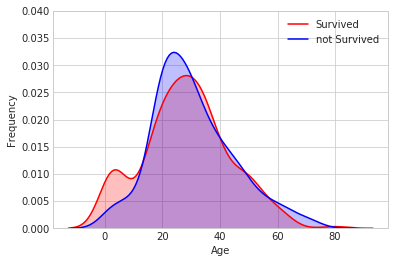

In [8]:
g = sns.kdeplot(train[(train.Survived==1)&(train['Age'].notnull())]['Age'], 
                color='Red', shade=True)
g = sns.kdeplot(train[(train.Survived==0)&(train['Age'].notnull())]['Age'], 
                color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Survived', 'not Survived'])
g.set_ylim(0, 0.04)

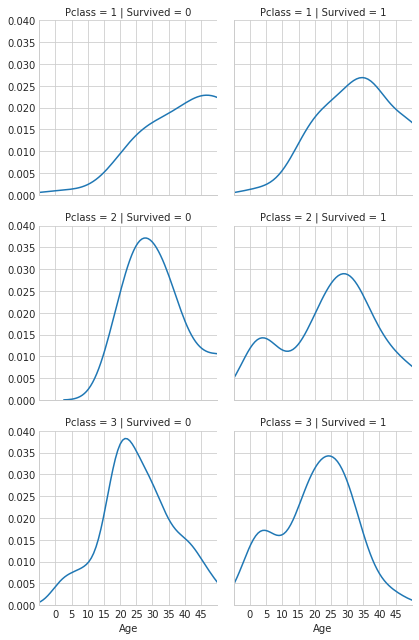

In [17]:
g = sns.FacetGrid(data=train[train['Age'].notnull()], 
                  row='Pclass', col='Survived', size=3, aspect=1)
g.map(sns.kdeplot, 'Age')
axes=g.axes
for i in range(0, 3):
    for j in range(0, 2):
        axes[i, j].set(ylim=(0,0.04), xlim=(-5, 50))
        axes[i, j].set_xticks(range(0, 50, 5))

In [19]:
# 对于p2和p3中小于14岁的乘客打标
combined['Minor'] = combined.loc[combined.Pclass > 1, 'Age'] < 14

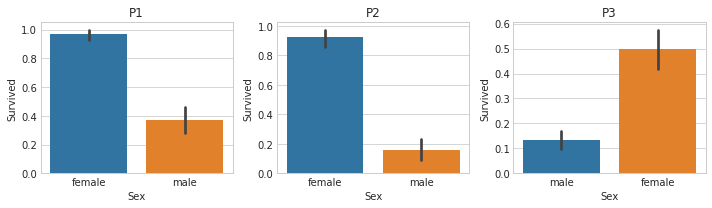

In [84]:
def pclass_sex_plot():
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(131)
    sns.barplot(data=combined[combined['Pclass']==1], x='Sex', y='Survived', ax=ax1)
    ax1.set_title('P1')
    ax2 = fig.add_subplot(132)
    sns.barplot(data=combined[combined['Pclass']==2], x='Sex', y='Survived', ax=ax2)
    ax2.set_title('P2')
    ax3 = fig.add_subplot(133)
    sns.barplot(data=combined[combined['Pclass']==3], x='Sex', y='Survived', ax=ax3)
    ax3.set_title('P3')
    fig.tight_layout()
    plt.show()
pclass_sex_plot()

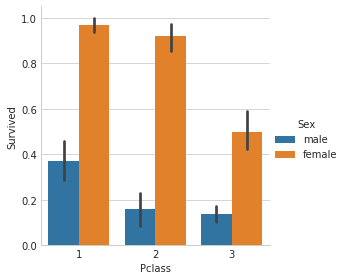

In [85]:
g = sns.factorplot(data=combined, x='Pclass', y='Survived', hue='Sex', kind='bar')

* 上图中可以发现，女乘客的存活率远高于男乘客。
* 但是p3中，女乘客的存活率，相比p1和p2低很多，接近50%左右
* 同时，p1的男乘客的存活率，相对与p2和p3高很多

In [30]:
# log(p/(1-p)) -> lr表达式
def log_lr(x):
    a = max(x, 0.01)
    a = min(x, 0.99)
    return np.log(a/(1-a))

In [31]:
survived_rate = train.groupby(['Pclass', 'Sex']).Survived.mean()
survived_rate

combined['SLogR'] = combined.apply(lambda x: log_lr(survived_rate[x.Pclass, x.Sex]), 
                                  axis=1)

In [33]:
# 看下SLogR变量与Surivived的相关性
combined[['Survived', 'SLogR']].corr()

,Survived,SLogR
Survived,1.000000,0.623145
SLogR,0.623145,1.000000


* 提取每位乘客的first name
* 每位乘客的家庭人数

In [37]:
def first_name(name):
    return name.split(',')[0].strip()
combined['FirstName'] = combined['Name'].map(first_name)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

In [ ]:
sns.kdeplot(combined['Fare'])

* 统计一下ticket title、 first name 和 fare 的出现频次

In [92]:
combined['TicketTitle'] = combined['Ticket'].map(lambda x: x.replace('.','').split(' ')[0])
freq_t = combined['TicketTitle'].value_counts().to_frame()
freq_t.columns = ['TicketTitleFreq']
freq_fn = combined['FirstName'].value_counts().to_frame()
freq_fn.columns = ['FirstNameFreq']

/home/lm/Softwares/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


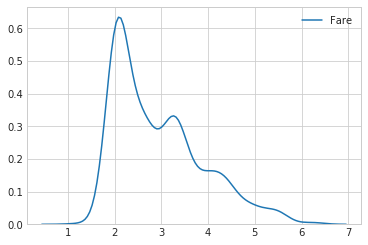

In [93]:
# 看一下 log(fare) 的分布情况
combined.loc[combined['Fare'].isnull(), 'Fare'] = combined['Fare'].mean()
sns.kdeplot(combined['Fare'].map(lambda x: np.log(x)))

In [94]:
combined['FareLogInt'] = combined['Fare'].map(lambda x: np.round(np.log(max(x, 0.1)), 2))
freq_fare = combined['FareLogInt'].value_counts().to_frame()
freq_fare.columns = ['FareLogIntFreq']

In [95]:
combined['TicketTitleFreq'] = combined.merge(freq_t, how='left', 
                                             left_on='TicketTitle', 
                                             right_index=True)['TicketTitleFreq']

combined['FirstNameFreq'] = combined.merge(freq_fn, how='left', 
                                           left_on='FirstName', 
                                           right_index=True)['FirstNameFreq']

combined['FareLogIntFreq'] = combined.merge(freq_fare, how='left', 
                                            left_on='FareLogInt', 
                                            right_index=True)['FareLogIntFreq']

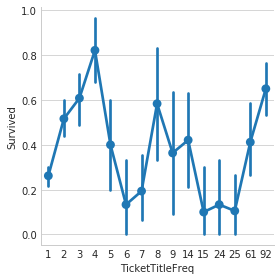

In [96]:
sns.factorplot(data=combined, x='TicketTitleFreq', y='Survived')